<a href="https://colab.research.google.com/github/SurangaPrasad/deep_learning/blob/main/transfer_learning_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Geting the setup (import libraries and setup device agnostic code)

In [1]:
import torch
import torchvision
from torch import nn
from torchvision import transforms

# get the torch version
torch.__version__

'2.1.0+cu121'

In [2]:
# set the device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"The selected device is {device}")

The selected device is cuda


### 2. Get data and split them to test, train and validation sets

Getting data from miniImageNet (https://drive.google.com/drive/folders/17a09kkqVivZQFggCw9I_YboJ23tcexNM)

In [3]:
import os
import gdown
from pathlib import Path
import requests
import tarfile
import zipfile

In [4]:
def download_and_extract(data_path,image_path, url, downlod_file_name, zip_file: bool=True):
  # Setup path to data folder

  # If the image folder doesn't exist, download it and prepare it...
  if image_path.is_dir():
      print(f"{image_path} directory exists.")
  else:
      print(f"Did not find {image_path} directory, creating one...")
      image_path.mkdir(parents=True, exist_ok=True)

      if zip_file:
        # Download zip file
        with open(data_path / downlod_file_name, "wb") as f:
            request = requests.get(url, verify=False)
            print("Downloading zip file...")
            f.write(request.content)

        # Unzip zip file
        with zipfile.ZipFile(data_path / downlod_file_name, "r") as zip_ref:
            print("Unzipping zip file...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        os.remove(data_path / downlod_file_name)

      else:
        # Download the tar file
        with open(data_path / downlod_file_name, "wb") as f:
            request = requests.get(url)
            print("Downloading tar file ...")
            f.write(request.content)

        # Unzip mini tar file
        with tarfile.open(data_path / downlod_file_name, "r") as tar:
            print("Unzipping tar file...")
            tar.extractall(image_path)

        # Remove .tar file
        os.remove(data_path / downlod_file_name)

In [5]:
data_path = Path("data/")
image_path = data_path / "mini_image_net"

url = 'https://drive.usercontent.google.com/download?id=107FTosYIeBn5QbynR46YG91nHcJ70whs&export=download&authuser=0&confirm=t&uuid=60b63e1a-f494-4f24-bdb1-b55131562a39&at=APZUnTVF0wI3FBlvrHXL3r-PlZjg:1704103333738'

download_and_extract(data_path, image_path, url,"mini_image_net.tar",False)

Did not find data/mini_image_net directory, creating one...
Unzipping tar file...


### 3. Create Datasets and DataLoaders

3.1 Creating a transform for torchvision.models (auto creation)

In [7]:
## geting the weight of pretrained model
weights = torchvision.models.ResNet18_Weights.DEFAULT

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [6]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_data,
    test_data,
    val_data,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Turn images into data loaders
  train_dataloader = torch.utils.data.DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = torch.utils.data.DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )
  valid_dataloader = torch.utils.data.DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, valid_dataloader

In [9]:
#Splitting data in to train, test and validation
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms)
#len(originalDataset)

random_gen = torch.Generator().manual_seed(42)

test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)

#getting classess
class_names = originalDataset.classes


In [10]:
# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = create_dataloaders(train_data,
                                                                               test_data,
                                                                               val_data,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, valid_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7908c52a2980>,
 <torch.utils.data.dataloader.DataLoader at 0x7908c52a2830>)

### 4. Getting a pretrained model

Earlier we got the weight for ***resnet18*** model. So let's import the same model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

In [21]:
model = torchvision.models.resnet18(weights, progress = True)

NameError: name 'weights' is not defined

In [22]:
#install torchinfo if it is not installed yet

!pip install torchinfo


In [32]:
import torchinfo
torchinfo.summary(model,
                  input_size = [32, 3, 224, 224],
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     36,864               True
│    │    └─BatchN

### 5. Freezing the base model and changing the output layer

In [33]:
#Freezing parameters
for param in model.parameters():
    param.requires_grad = False

Now we can set the output layer according to the number of classes in the EuroSat data set

In [34]:
# output_shape = len(eurosat_dataset.classes)
output_shape = len(originalDataset.classes)

In [35]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the fc layer and seed it to the target device
model.fc = torch.nn.Linear(in_features=512,
                           out_features=output_shape, # same number of output units as our number of classes
                           bias=True).to(device)

Now let's see the summary again

In [36]:
torchinfo.summary(model,
                  input_size = [32, 3, 224, 224],
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 64]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

### 6. Model training

Since this is a multiclass classification problem, we can use nn.CrossEntropyLoss() and we use torch.optim.Adam() as our optimizer with lr=0.001

In [37]:
# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# evaluation function
def eval(net, data_loader):
    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()
    net.eval()
    correct = 0.0
    num_images = 0.0
    for i_batch, (images, labels) in enumerate(data_loader):
        if use_cuda:
            images = images.cuda()
            labels = labels.cuda()
        outs = net(images)

        loss = loss_function(outs, labels)
#         _, preds = outs.max(1)
        preds = outs.argmax(dim=1)
        correct += preds.eq(labels).sum()
        num_images += len(labels)

    acc = correct / num_images
    return acc , loss

# training function
def train(net, train_loader, valid_loader, loss_function, optimizer, epoches):

    use_cuda = torch.cuda.is_available()
    if use_cuda:
        net = net.cuda()

    # Create empty results dictionary
    train_val_results = {"train_loss": [],
                         "train_acc": [],
                         "val_loss": [],
                         "val_acc":[]
                        }

    for epoch in range(epoches):
        net.train()
        correct = 0.0 # used to accumulate number of correctly recognized images
        num_images = 0.0 # used to accumulate number of images
        for i_batch, (images, labels) in enumerate(train_loader):
            if use_cuda:
                images = images.cuda()
                labels = labels.cuda()

            # forward propagation
            outs = net(images)
            # backward propagation
            loss = loss_function(outs, labels)
            loss.backward()
            # calculating the accuracy
            preds = outs.argmax(dim=1)
            correct += preds.eq(labels).sum()

            # update parameters
            optimizer.step()
            optimizer.zero_grad()
            num_images += len(labels)


        acc = correct / num_images
        acc_eval,loss_eval = eval(net, valid_loader)

        train_val_results["train_loss"].append(loss)
        train_val_results["train_acc"].append(acc)
        train_val_results["val_loss"].append(loss_eval)
        train_val_results["val_acc"].append(acc_eval)

        print('epoch: %d, lr: %f, accuracy: %f, loss: %f, valid accuracy: %f' % (epoch, optimizer.param_groups[0]['lr'], acc, loss.item(), acc_eval))

    return train_val_results

In [39]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = train(model, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = eval(model, test_dataloader)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

epoch: 0, lr: 0.001000, accuracy: 0.308073, loss: 2.062748, valid accuracy: 0.535417
epoch: 1, lr: 0.001000, accuracy: 0.657552, loss: 1.321801, valid accuracy: 0.654688
epoch: 2, lr: 0.001000, accuracy: 0.737240, loss: 1.251256, valid accuracy: 0.690625
epoch: 3, lr: 0.001000, accuracy: 0.772917, loss: 1.202444, valid accuracy: 0.701823
epoch: 4, lr: 0.001000, accuracy: 0.805469, loss: 0.923480, valid accuracy: 0.723177
epoch: 5, lr: 0.001000, accuracy: 0.828646, loss: 0.669987, valid accuracy: 0.714844
epoch: 6, lr: 0.001000, accuracy: 0.839844, loss: 0.554739, valid accuracy: 0.716667
epoch: 7, lr: 0.001000, accuracy: 0.867708, loss: 0.647769, valid accuracy: 0.726302
epoch: 8, lr: 0.001000, accuracy: 0.867188, loss: 0.491101, valid accuracy: 0.725000
epoch: 9, lr: 0.001000, accuracy: 0.890104, loss: 0.596743, valid accuracy: 0.723698
accuracy on testing data: 0.729688
[INFO] Total training time: 321.562 seconds


### 7.Evaluate model by plotting loss curves

In [17]:
import matplotlib.pyplot as plt

# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "val_loss": [...],
             "val_acc": [...]}
    """


    epochs = range(len(results["train_loss"]))

    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []


    for i in epochs:
      train_loss.append(results["train_loss"][i].detach().cpu().numpy())
      test_loss.append(results["val_loss"][i].detach().cpu().numpy())
      train_accuracy.append(results["train_acc"][i].detach().cpu().numpy())
      test_accuracy.append(results["val_acc"][i].detach().cpu().numpy())

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

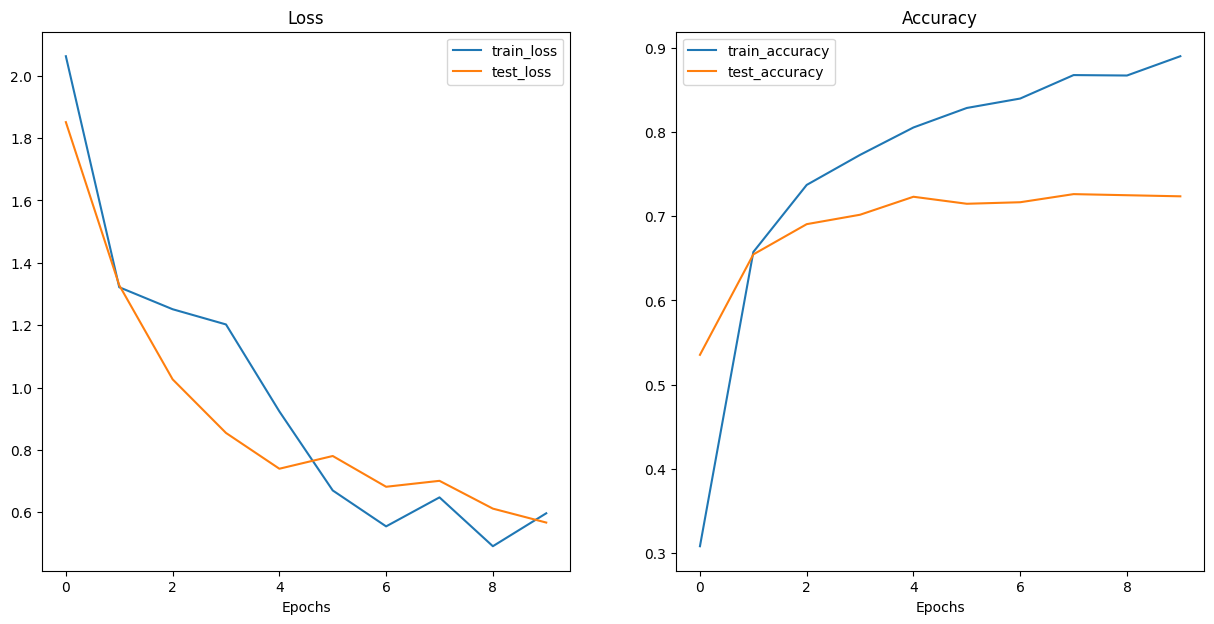

In [41]:
plot_loss_curves(train_val_results)

# epochs = range(len(train_val_results["train_loss"]))
# len(train_val_results["train_loss"])

### 8. Saving the model

In [42]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "resnt18_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/resnt18_model.pth


### 9. Choose 100 images from EuroSAT dataset and select the training set

In [16]:
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "eurosat"
url = "https://madm.dfki.de/files/sentinel/EuroSAT.zip"

download_and_extract(data_path,image_path, url, "eurosat.zip")

data/eurosat directory exists.


In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import random

eurosat_dataset = torchvision.datasets.ImageFolder(image_path / "2750")



def getEuroSatDataLoaders(starting_number):

  sample_list = eurosat_dataset.imgs
  unique_categories = set(label for _, label in sample_list)
  selected_categories = random.sample(unique_categories, k=5)
  category_counters = {label: 0 for label in selected_categories}

  # Initialize lists to store selected images and labels
  selected_images = []
  selected_labels = []


  # Iterate through the sample list to select 20 images from each of the 5 categories
  for image_path, label in sample_list:
      if label in selected_categories and category_counters[label] < starting_number*20 + 20:
          if category_counters[label] > starting_number*20: ### select another set of images and labels according to the starting_number
            selected_images.append(image_path)
            selected_labels.append(label)
          category_counters[label] += 1
  # Randomly choose 25 images for training (5 from each category)
  training_images = []
  training_labels = []
  testing_images = []
  testing_labels = []


  category_counters = {label: 0 for label in selected_categories} ## reset all category counters

  # print(f"Selected Categories {selected_categories} \n category_counters {category_counters}")

  for image_path, label in sample_list:
      if label in selected_categories and category_counters[label] < 20:
          if category_counters[label] < 5:
              # Add to training set
              training_images.append(image_path)
              training_labels.append(label)
          else:
              # Add to testing set
              testing_images.append(image_path)
              testing_labels.append(label)
          category_counters[label] += 1

  # Define transforms (you can customize these)
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
  ])
  # Define a custom dataset class
  class CustomDataset(Dataset):
      def __init__(self, images, labels, transform=None):
          self.images = images
          self.labels = labels
          self.transform = transform

      def __len__(self):
          return len(self.images)

      def __getitem__(self, idx):
          image_path, label = self.images[idx], self.labels[idx]
          image = Image.open(image_path).convert("RGB")

          if self.transform:
              image = self.transform(image)

          return image, label

  # Create datasets and data loaders for training and testing
  train_dataset = CustomDataset(training_images, training_labels, transform=transform)
  test_dataset = CustomDataset(testing_images, testing_labels, transform=transform)

  # Define batch size
  batch_size = 32

  # Create DataLoader instances
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader




### 9. Fine-tune the pretrained model

Converting above training and testing data sets in to data loaders

In [61]:
import random
import numpy as np
import torchvision
import torch

data_path2 = Path("models/")
weights = torchvision.models.ResNet18_Weights.DEFAULT
loaded_model = torchvision.models.resnet18(weights, progress = True)

#Freezing parameters
for param in loaded_model.parameters():
    param.requires_grad = False

#Unfreez layer 4 and last layer

for param in loaded_model.layer4.parameters():
    param.requires_grad = True

output_shape = len(originalDataset.classes)

loaded_model.fc = torch.nn.Linear(in_features=512,
                                  out_features=output_shape, # same number of output units as our number of classes
                                  bias=True).to(device)
saved_path = data_path2 / "resnt18_model.pth"
loaded_model.load_state_dict(torch.load(saved_path))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


<All keys matched successfully>

In [62]:
torchinfo.summary(loaded_model,
                  input_size = [32, 3, 224, 224],
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 64]             --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    └─BasicBlock (0)                    [32, 64, 56, 56]     [32, 64, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (36,864)             False
│    │    

In [63]:
# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 20
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=0.001)

for staring_number in range(0,10):
  train_loader, test_loader = getEuroSatDataLoaders(staring_number)
  train_val_results = train(loaded_model, train_loader, test_loader, loss_function, optimizer, epoches)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

<ipython-input-44-666319a8f3f5>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_categories = random.sample(unique_categories, k=5)


epoch: 0, lr: 0.001000, accuracy: 0.000000, loss: 7.011235, valid accuracy: 0.360000
epoch: 1, lr: 0.001000, accuracy: 1.000000, loss: 0.015787, valid accuracy: 0.546667
epoch: 2, lr: 0.001000, accuracy: 1.000000, loss: 0.000531, valid accuracy: 0.520000
epoch: 3, lr: 0.001000, accuracy: 1.000000, loss: 0.000157, valid accuracy: 0.520000
epoch: 4, lr: 0.001000, accuracy: 1.000000, loss: 0.000073, valid accuracy: 0.506667
epoch: 5, lr: 0.001000, accuracy: 1.000000, loss: 0.000040, valid accuracy: 0.520000
epoch: 6, lr: 0.001000, accuracy: 1.000000, loss: 0.000025, valid accuracy: 0.533333
epoch: 7, lr: 0.001000, accuracy: 1.000000, loss: 0.000017, valid accuracy: 0.533333
epoch: 8, lr: 0.001000, accuracy: 1.000000, loss: 0.000013, valid accuracy: 0.533333
epoch: 9, lr: 0.001000, accuracy: 1.000000, loss: 0.000010, valid accuracy: 0.533333
epoch: 10, lr: 0.001000, accuracy: 1.000000, loss: 0.000008, valid accuracy: 0.533333
epoch: 11, lr: 0.001000, accuracy: 1.000000, loss: 0.000006, val

### 10 VGG model

In [8]:
# collecting the default weights
weights_vgg = torchvision.models.VGG11_Weights.IMAGENET1K_V1

# Get the transforms used to create our pretrained weights
auto_transforms_vgg = weights_vgg.transforms()

#Splitting data in to train, test and validation
data_path = Path("data/")
image_path = data_path / "mini_image_net"
originalDataset = torchvision.datasets.ImageFolder(image_path/ "train", transform = auto_transforms_vgg)
random_gen = torch.Generator().manual_seed(42)
test_data, train_data, val_data = torch.utils.data.random_split(originalDataset, [0.8, 0.1, 0.1] , generator=random_gen)

#getting classess
class_names = originalDataset.classes

# Create training, testing and validation DataLoaders
train_dataloader, test_dataloader,valid_dataloader = create_dataloaders(train_data,
                                                                        test_data,
                                                                        val_data,
                                                                        transform=auto_transforms_vgg, # perform same data transforms on our own data as the pretrained model
                                                                        batch_size=32) # set mini-batch size to 32
#Import the model

model_vgg11 = torchvision.models.vgg11(weights_vgg, progress = True)

#Freezing parameters
for param in model_vgg11.parameters():
    param.requires_grad = False

output_shape = len(originalDataset.classes)

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Recreate the fc layer and seed it to the target device
# model_vgg16.classifier = torch.nn.Linear(in_features=4096,
#                            out_features=output_shape, # same number of output units as our number of classes
#                            bias=True).to(device)
# Modify the last fully connected layer
model_vgg11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape,
                                              bias=True).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 134MB/s]


In [13]:
# Define loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg11.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 10

train_val_results = train(model_vgg11, train_dataloader, valid_dataloader, loss_function, optimizer, epoches)
acc_test,loss_test = eval(model_vgg11, test_dataloader)

print('accuracy on testing data: %f' % acc_test) #  a reference output is provided below:

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

epoch: 0, lr: 0.001000, accuracy: 0.531510, loss: 1.353464, valid accuracy: 0.711979
epoch: 1, lr: 0.001000, accuracy: 0.776042, loss: 0.870564, valid accuracy: 0.721875
epoch: 2, lr: 0.001000, accuracy: 0.829948, loss: 0.551149, valid accuracy: 0.721875
epoch: 3, lr: 0.001000, accuracy: 0.866406, loss: 0.505480, valid accuracy: 0.731510
epoch: 4, lr: 0.001000, accuracy: 0.894010, loss: 0.097346, valid accuracy: 0.729948
epoch: 5, lr: 0.001000, accuracy: 0.922656, loss: 0.214242, valid accuracy: 0.731250
epoch: 6, lr: 0.001000, accuracy: 0.928125, loss: 0.324138, valid accuracy: 0.730729
epoch: 7, lr: 0.001000, accuracy: 0.943490, loss: 0.190918, valid accuracy: 0.727083
epoch: 8, lr: 0.001000, accuracy: 0.947396, loss: 0.208660, valid accuracy: 0.730208
epoch: 9, lr: 0.001000, accuracy: 0.951042, loss: 0.127408, valid accuracy: 0.722135
accuracy on testing data: 0.732715
[INFO] Total training time: 364.910 seconds


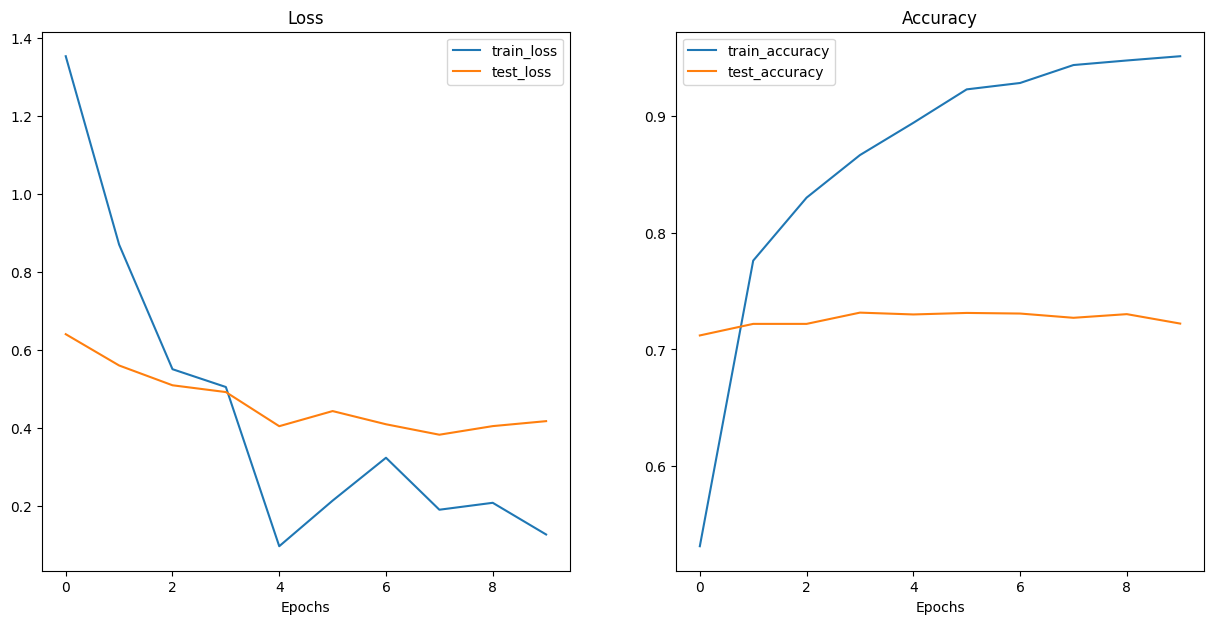

In [18]:
plot_loss_curves(train_val_results)

In [25]:
import random
import numpy as np
import torchvision
import torch
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "vgg11_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_vgg11.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


data_path2 = Path("models/")
weights_vgg = torchvision.models.VGG11_Weights.IMAGENET1K_V1

##load model
loaded_model_vgg11 = torchvision.models.vgg11(weights_vgg, progress = True)


#Freezing parameters
for param in loaded_model_vgg11.parameters():
    param.requires_grad = False

#Unfreez layer 4 and last layer

for param in loaded_model_vgg11.classifier.parameters():
    param.requires_grad = True

output_shape = len(originalDataset.classes)

loaded_model_vgg11.classifier[-1] = torch.nn.Linear(in_features=4096,  # Assuming the default in_features for VGG16
                                              out_features=output_shape,
                                              bias=True).to(device)
saved_path = data_path2 / "vgg11_model.pth"
loaded_model_vgg11.load_state_dict(torch.load(saved_path))

# Start the timer
from timeit import default_timer as timer
start_time = timer()
epoches = 20
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(loaded_model_vgg11.parameters(), lr=0.001)

for staring_number in range(0,10):
  train_loader, test_loader = getEuroSatDataLoaders(staring_number)
  train_val_results = train(loaded_model_vgg11, train_loader, test_loader, loss_function, optimizer, epoches)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

Saving model to: models/vgg11_model.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
<ipython-input-15-666319a8f3f5>:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_categories = random.sample(unique_categories, k=5)


epoch: 0, lr: 0.001000, accuracy: 0.000000, loss: 6.789042, valid accuracy: 0.546667
epoch: 1, lr: 0.001000, accuracy: 0.600000, loss: 0.961675, valid accuracy: 0.613333
epoch: 2, lr: 0.001000, accuracy: 0.920000, loss: 0.289899, valid accuracy: 0.706667
epoch: 3, lr: 0.001000, accuracy: 1.000000, loss: 0.012734, valid accuracy: 0.746667
epoch: 4, lr: 0.001000, accuracy: 0.960000, loss: 0.065211, valid accuracy: 0.760000
epoch: 5, lr: 0.001000, accuracy: 1.000000, loss: 0.000009, valid accuracy: 0.786667
epoch: 6, lr: 0.001000, accuracy: 0.960000, loss: 0.033351, valid accuracy: 0.746667
epoch: 7, lr: 0.001000, accuracy: 0.960000, loss: 0.147956, valid accuracy: 0.760000
epoch: 8, lr: 0.001000, accuracy: 1.000000, loss: 0.005636, valid accuracy: 0.760000
epoch: 9, lr: 0.001000, accuracy: 1.000000, loss: 0.000031, valid accuracy: 0.680000
epoch: 10, lr: 0.001000, accuracy: 0.960000, loss: 0.102569, valid accuracy: 0.626667
epoch: 11, lr: 0.001000, accuracy: 1.000000, loss: 0.000000, val

In [23]:
import torchinfo
torchinfo.summary(model_vgg11,
                  input_size = [32, 3, 224, 224],
                  verbose=0,
                  col_names=["input_size", "output_size", "num_params", "trainable"],
                  col_width=20,
                  row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [32, 3, 224, 224]    [32, 64]             --                   Partial
├─Sequential (features)                  [32, 3, 224, 224]    [32, 512, 7, 7]      --                   False
│    └─Conv2d (0)                        [32, 3, 224, 224]    [32, 64, 224, 224]   (1,792)              False
│    └─ReLU (1)                          [32, 64, 224, 224]   [32, 64, 224, 224]   --                   --
│    └─MaxPool2d (2)                     [32, 64, 224, 224]   [32, 64, 112, 112]   --                   --
│    └─Conv2d (3)                        [32, 64, 112, 112]   [32, 128, 112, 112]  (73,856)             False
│    └─ReLU (4)                          [32, 128, 112, 112]  [32, 128, 112, 112]  --                   --
│    └─MaxPool2d (5)                     [32, 128, 112, 112]  [32, 128, 56, 56]    --                   --
│    └─Conv2d (6